In [ ]:
from enum import auto
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics  import classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [34]:
# Bỏ qua hàng đầu tiên, dùng hàng 2 làm header
df = pd.read_csv("SWAT.csv",header=1, low_memory=False)

In [35]:
time_candidates = [c for c in df.columns if 'time' in c.lower() or 'timestamp' in c.lower()]
if not time_candidates:
    timestamp_col = df.columns[0]
else:
    timestamp_col = time_candidates[0]

df = df[~df[timestamp_col].astype(str).str.lower().eq(timestamp_col.lower())]
df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce", utc=True)
df = df.dropna(subset=[timestamp_col])
df = df.set_index(timestamp_col)

print("Cột thời gian được sử dụng:", timestamp_col)

Cột thời gian được sử dụng: GMT +0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17088\1033324384.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce", utc=True)


In [36]:
attack_periods = [
    # Attack 1: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:08:46', '2019-07-20 07:10:31'),
    # Attack 2: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:15:00', '2019-07-20 07:19:32'),
    # Attack 3: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:26:57', '2019-07-20 07:30:48'),
    # Attack 4: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:38:50', '2019-07-20 07:46:20'),
    # Attack 5: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:54:00', '2019-07-20 07:56:00'),
    # Attack 6: 16h (GMT+8) -> 8h (GMT+0)
    ('2019-07-20 08:02:56', '2019-07-20 08:16:18')
]

attack_datetime_periods = [
    (pd.to_datetime(start).tz_localize("UTC"), pd.to_datetime(end).tz_localize("UTC"))
    for start, end in attack_periods
]

df['Attack'] = 0
for start, end in attack_datetime_periods:
    df.loc[start:end, 'Attack'] = 1

print("Số mẫu Attack:", df['Attack'].sum())
print("Tỷ lệ Attack:", df['Attack'].mean() * 100)

Số mẫu Attack: 1981
Tỷ lệ Attack: 13.210189383835688


In [37]:
plt.rcParams['figure.figsize'] = (15, 5)
status_cols = [col for col in df.columns if df[col].astype(str).str.contains("Active|Inactive", case=False).any()]

print("\n Các cột có Active/Inactive:", status_cols)

for col in status_cols:
    df[col] = df[col].map({'Active': 1, 'Inactive': 0})

# print(df[status_cols].head())

target_column = 'Attack'
feature_columns = df.columns.drop(target_column)

for col in feature_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

feature_std = df[feature_columns].std()
useless_columns = feature_std[feature_std == 0].index

if not useless_columns.empty:
    print("\nCác cột không có biến thiên (std=0) và có thể loại bỏ:")
    print(list(useless_columns))
    print("Số cột bị loại bỏ:", len(useless_columns))
    # df.drop(columns=useless_columns, inplace=True)
else:
    print("\nKhông có cột nào bị loại bỏ do không có biến thiên.")


 Các cột có Active/Inactive: ['LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'LS 401', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603']

Các cột không có biến thiên (std=0) và có thể loại bỏ:
['P102 Status', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'P2_STATE', 'P201 Status', 'P202 Status', 'P204 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'P302 Status', 'AIT 401', 'LS 401', 'P4_STATE', 'P402 Status', 'P403 Status', 'P404 Status', 'MV 502', 'MV 503', 'MV 504', 'P5_STATE', 'P501 Status', 'P502 Status', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603', 'P6 STATE', 'P602 Status', 'P603 Status']
Số cột bị loại bỏ: 33


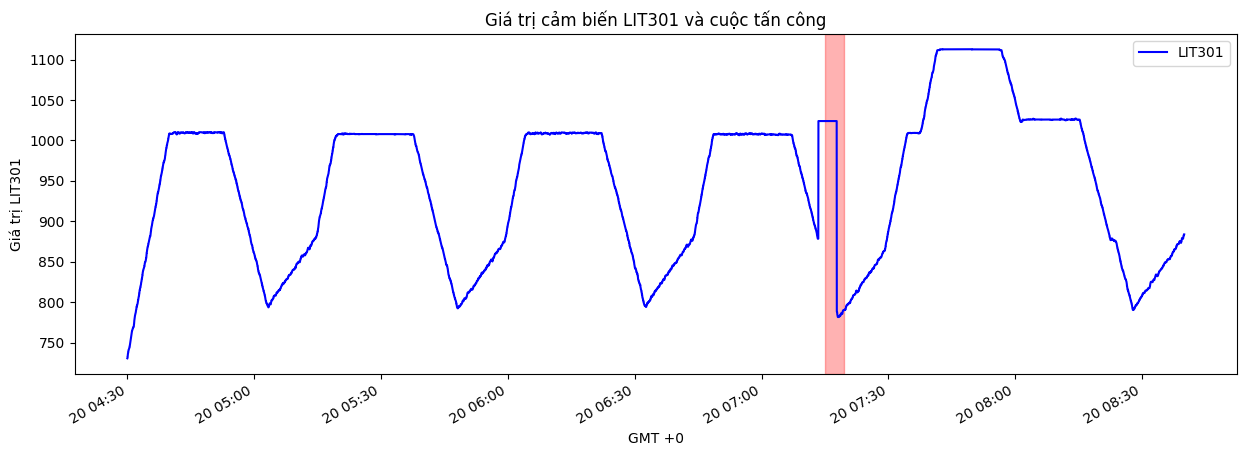

In [38]:
# --------------------------------------------------------------------------------
# Visualize attack periods on a specific sensor
fig, ax = plt.subplots()

df['LIT 301'].plot(ax=ax, label='LIT301', color='blue')

start,end = attack_datetime_periods[1]
ax.axvspan(start, end, color='red', alpha=0.3, label ='_nolegend_')

ax.set_title('Giá trị cảm biến LIT301 và cuộc tấn công')
ax.set_ylabel('Giá trị LIT301')
ax.legend()
plt.show()


Không tìm thấy cột nào chứa toàn giá trị NaN.


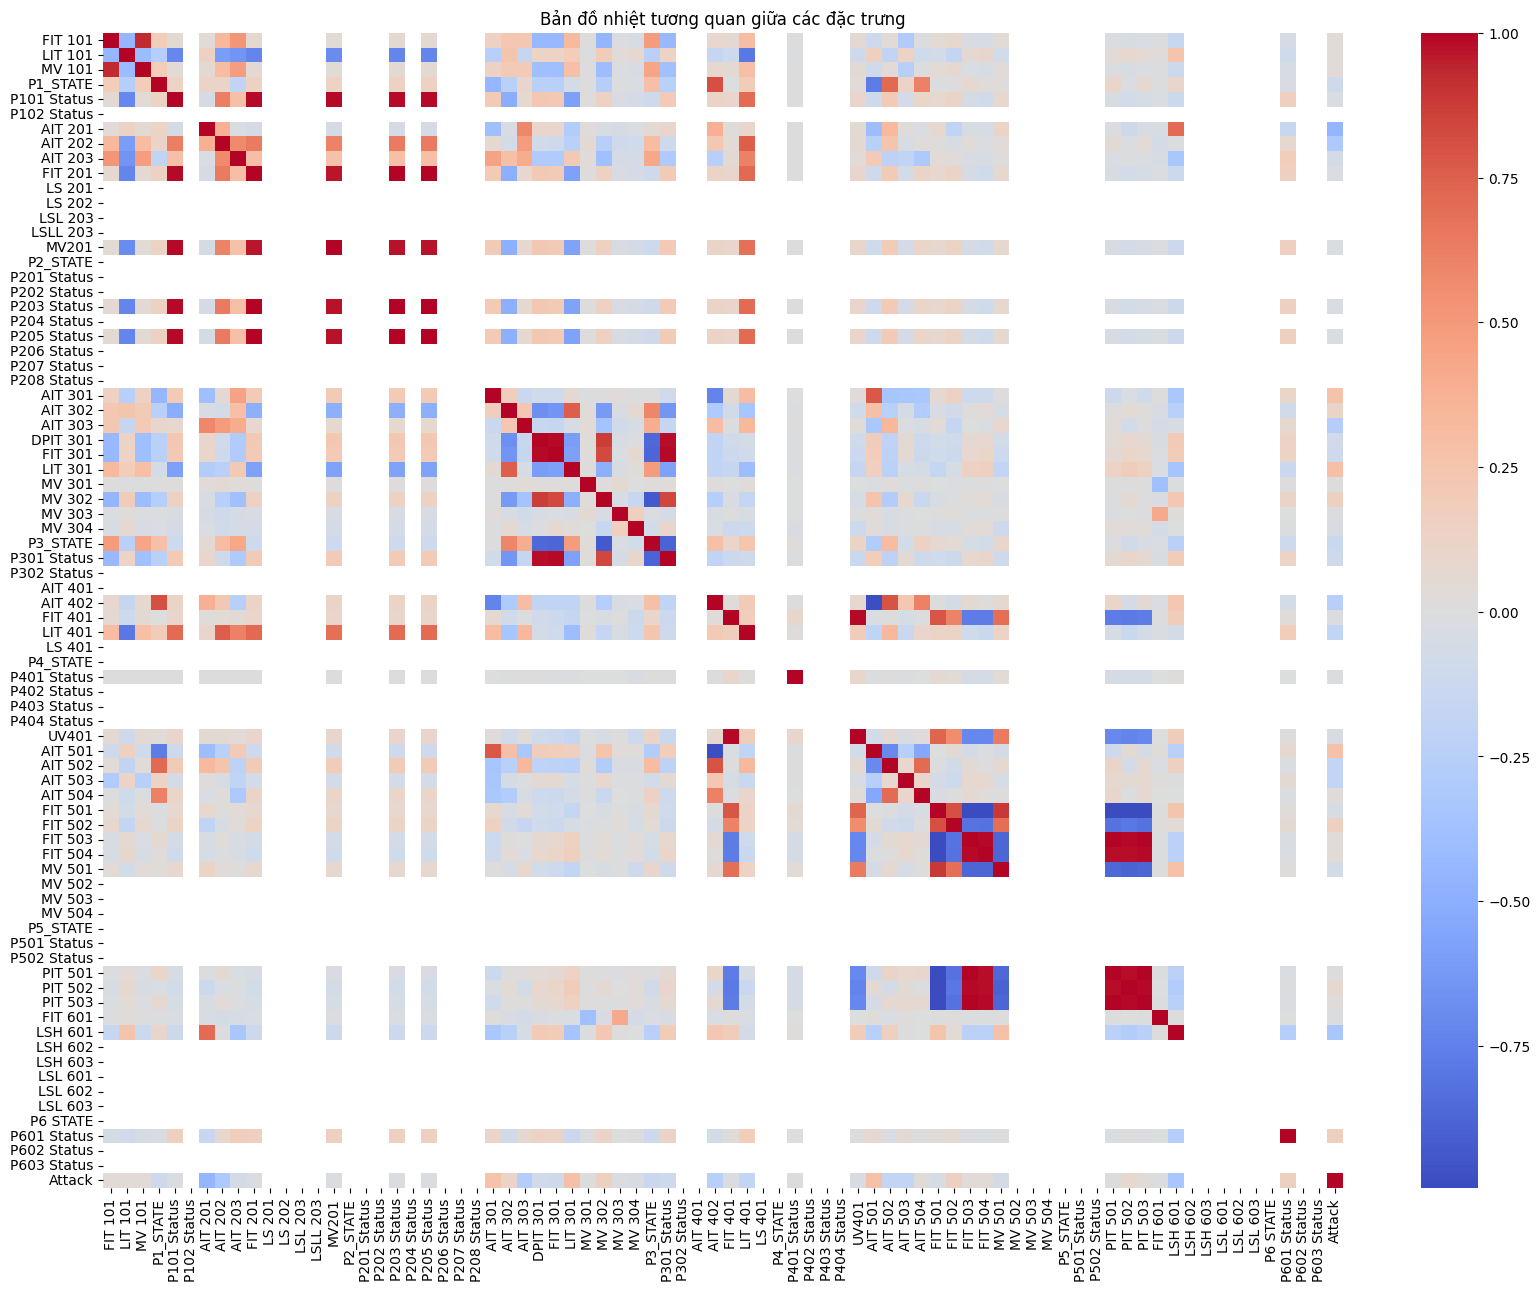

In [39]:
#--------------------------------------------------------------------------------\
# Feature correlations analysis

nan_columns = df.columns[df.isnull().all()]

if not nan_columns.empty:
    print("\nCÁC CỘT BỊ TRỐNG TRÊN HEATMAP (do toàn giá trị NaN):")
    print(list(nan_columns))
else:
    print("\nKhông tìm thấy cột nào chứa toàn giá trị NaN.")

corr_matrix = df.corr() 

plt.figure(figsize=(20, 15))

sns.heatmap(corr_matrix, cmap='coolwarm', center=0)

plt.title('Bản đồ nhiệt tương quan giữa các đặc trưng')

plt.show()

In [40]:
#---------------------------------------------------------------------------------
# Select top features based on correlation with 'Attack'

selected_features = ['FIT 101', 'LIT 101', 'MV 101', 'P1_STATE', 'P101 Status', 'AIT 201', 'AIT 202', 'AIT 203', 'FIT 201', 'MV201', 'P203 Status', 'P205 Status',
                    'AIT 301', 'AIT 302', 'AIT 303', 'DPIT 301', 'FIT 301', 'LIT 301', 'MV 301', 'MV 302', 'MV 303', 'MV 304', 'P3_STATE', 'P301 Status', 
                    'AIT 402', 'FIT 401', 'LIT 401', 'P401 Status', 'UV401', 'AIT 501', 'AIT 502', 'AIT 503', 'AIT 504', 'FIT 501', 'FIT 502', 'FIT 503',
                    'FIT 504', 'MV 501', 'PIT 501', 'PIT 502', 'PIT 503', 'FIT 601', 'LSH 601', 'P601 Status']


df_model = df[selected_features + ['Attack']].copy()

print(f"Đã tạo DataFrame mới với {len(selected_features)} đặc trưng được chọn.")

print(df_model.head())


Đã tạo DataFrame mới với 44 đặc trưng được chọn.
                                  FIT 101   LIT 101  MV 101  P1_STATE  \
GMT +0                                                                  
2019-07-20 04:30:00+00:00             0.0  729.8658       1         3   
2019-07-20 04:30:01+00:00             0.0  729.4340       1         3   
2019-07-20 04:30:02.004013+00:00      0.0  729.1200       1         3   
2019-07-20 04:30:03.004013+00:00      0.0  728.6882       1         3   
2019-07-20 04:30:04+00:00             0.0  727.7069       1         3   

                                  P101 Status     AIT 201   AIT 202  \
GMT +0                                                                
2019-07-20 04:30:00+00:00                   2  142.527557  9.293002   
2019-07-20 04:30:01+00:00                   2  142.527557  9.293002   
2019-07-20 04:30:02.004013+00:00            2  142.527557  9.293002   
2019-07-20 04:30:03.004013+00:00            2  142.527557  9.289157   
2019-07-20 04

In [41]:
#---------------------------------------------------------------------------------
# missing value imputation


print(f"Số giá trị NaN trước khi xử lý: {df_model.isnull().sum().sum()}")

df_model.ffill(inplace=True)

df_model.bfill(inplace=True)

print(f"Số giá trị NaN sau khi xử lý: {df_model.isnull().sum().sum()}")

Số giá trị NaN trước khi xử lý: 0
Số giá trị NaN sau khi xử lý: 0


In [42]:
#- ---------------------------------------------------------------------------
# Split data into train and test sets based on time

from sklearn.model_selection import train_test_split

split_timestamp = pd.to_datetime('2019-07-20 07:00:00').tz_localize("UTC")

# df_train = df_model.loc[df_model.index <= split_timestamp]

# df_test = df_model.loc[df_model.index > split_timestamp]

# print("split timestamp:", split_timestamp)
# print(f"Train set: {df_train.shape}, Test set: {df_test.shape}")

df_before_attack = df_model.loc[df_model.index <= split_timestamp]
df_after_attack = df_model.loc[df_model.index > split_timestamp]

df_train_core = df_before_attack.copy()

df_normal_after_attack = df_after_attack[df_after_attack['Attack'] == 0]

df_attacks = df_after_attack[df_after_attack['Attack'] == 1]

df_normal_to_add_to_train, df_normal_for_test = train_test_split(df_normal_after_attack, test_size=0.5, random_state=42) 

df_train = pd.concat([df_train_core, df_normal_to_add_to_train])
df_test = pd.concat([df_normal_for_test, df_attacks])

df_train.sort_index(inplace=True)
df_test.sort_index(inplace=True)

print("--- Phân chia dữ liệu kết hợp hoàn tất ---")
print(f"Kích thước tập Train mới: {df_train.shape}")
print(f"Kích thước tập Test mới: {df_test.shape}")



--- Phân chia dữ liệu kết hợp hoàn tất ---
Kích thước tập Train mới: (11005, 45)
Kích thước tập Test mới: (3991, 45)


In [43]:
# label distribution

print("\n--- Phân bố nhãn trong tập train ---")
print(df_train['Attack'].value_counts())

print("\n--- Phân bố nhãn trong tập test ---")
print(df_test['Attack'].value_counts())

X_train = df_train[selected_features]
y_train = df_train['Attack']

X_test = df_test[selected_features]
y_test = df_test['Attack']

print("Completed data preprocessing and splitting!")


--- Phân bố nhãn trong tập train ---
Attack
0    11005
Name: count, dtype: int64

--- Phân bố nhãn trong tập test ---
Attack
0    2010
1    1981
Name: count, dtype: int64
Completed data preprocessing and splitting!


In [ ]:
#---------------------------------------------------------------------------------
# Chuẩn hóa dữ liệu(data scaling)



# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# print("Dữ liệu đã được chuẩn hóa.")

X_train_core = df_train_core[selected_features]

scaler = StandardScaler()
scaler.fit(X_train_core)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dữ liệu đã được chuẩn hóa.")




Dữ liệu đã được chuẩn hóa.


In [45]:
#---------------------------------------------------------------------------------
# Train LSTM Autoencoder model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

def create_sequences(X, time_steps=10):
    Xs = []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
    return np.array(Xs)


TIME_STEPS = 10

X_train_seq = create_sequences(X_train_scaled, TIME_STEPS)
X_test_seq = create_sequences(X_test_scaled, TIME_STEPS)

y_test_seq = y_test.iloc[TIME_STEPS:]

print(f"Dữ liệu train ban đầu: {X_train_scaled.shape}")
print(f"Dữ liệu train sau khi tạo chuỗi: {X_train_seq.shape}")
print(f"Dữ liệu test ban đầu: {X_test_scaled.shape}")
print(f"Dữ liệu test sau khi tạo chuỗi: {X_test_seq.shape}")
print(f"Nhãn test sau khi điều chỉnh: {y_test_seq.shape}")

Dữ liệu train ban đầu: (11005, 44)
Dữ liệu train sau khi tạo chuỗi: (10995, 10, 44)
Dữ liệu test ban đầu: (3991, 44)
Dữ liệu test sau khi tạo chuỗi: (3981, 10, 44)
Nhãn test sau khi điều chỉnh: (3981,)


In [ ]:
from tensorflow.keras.layers import Dropout
n_samples, n_timesteps, n_features = X_train_seq.shape

# Xây dựng kiến trúc mô hình
lstm_autoencoder = Sequential([
    # Encoder
    LSTM(32, activation='tanh', input_shape=(n_timesteps, n_features), return_sequences=True),
    Dropout(0.2),
    LSTM(16, activation='tanh', return_sequences=False),
    RepeatVector(n_timesteps), 

    # Decoder
    LSTM(16, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh', return_sequences=True),
    TimeDistributed(Dense(n_features)) 
])


lstm_autoencoder.compile(optimizer='adam', loss='mae')
lstm_autoencoder.summary()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 10, 32)         │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 10, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 10, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 44)         │         1,452 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,828 (89.17 KB)

 Trainable params: 22,828 (89.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.5529 - val_loss: 4.7977
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4326 - val_loss: 4.7525
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3716 - val_loss: 4.7570
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3350 - val_loss: 4.8487
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3135 - val_loss: 4.7921
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2991 - val_loss: 4.7373
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2885 - val_loss: 4.7021
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2801 - val_loss: 4.6925
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2733 - val_loss: 4.7221
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2673 - val_loss: 4.7009
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2623 - val_loss: 4.7353
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

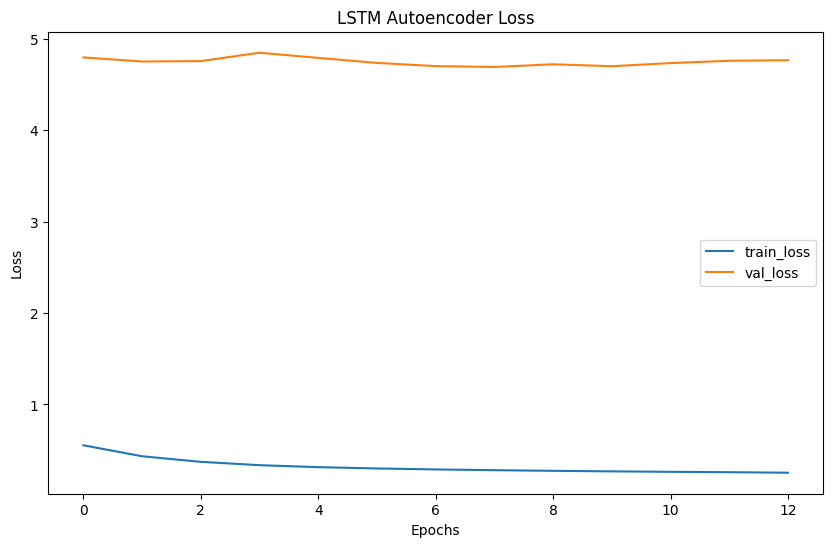

In [47]:
#---------------------------------------------------------------------------------
# Training LSTM Autoencoder

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

history = lstm_autoencoder.fit(
    X_train_seq, X_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    shuffle=False
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('LSTM Autoencoder Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Ngưỡng Lỗi Tái tạo (LSTM) được xác định là: 76.1329
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

---Báo cáo phân loại cho mô hình LSTM Autoencoder:---
              precision    recall  f1-score   support

   Normal(0)       0.51      1.00      0.67      2000
   Attack(1)       0.95      0.03      0.05      1981

    accuracy                           0.51      3981
   macro avg       0.73      0.51      0.36      3981
weighted avg       0.73      0.51      0.36      3981

Confusion Matrix:


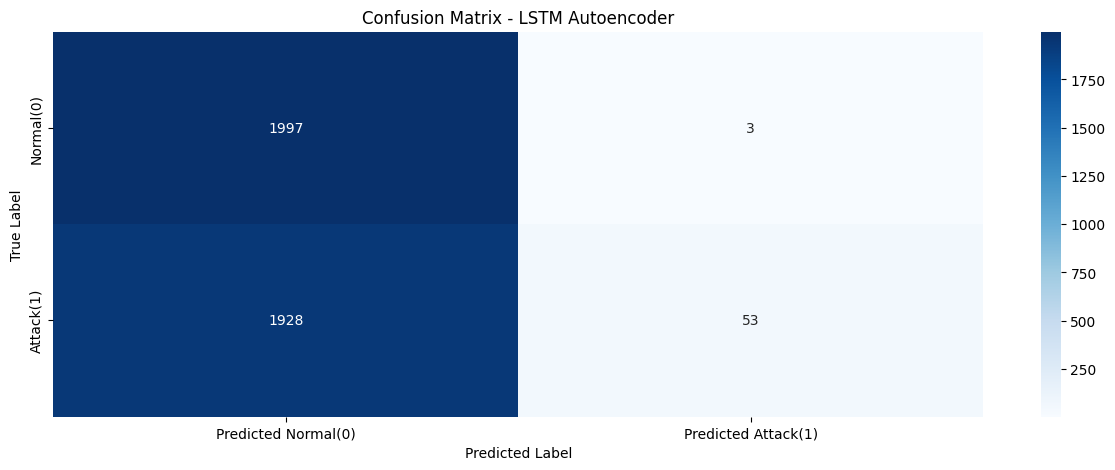

In [48]:
train_seq_predictions = lstm_autoencoder.predict(X_train_seq)
train_seq_mae = np.mean(np.abs(train_seq_predictions - X_train_seq), axis=(1,2))

threshold_lstm  = np.max(train_seq_mae)

print(f"\nNgưỡng Lỗi Tái tạo (LSTM) được xác định là: {threshold_lstm:.4f}")

test_seq_predictions = lstm_autoencoder.predict(X_test_seq)
test_seq_mae = np.mean(np.abs(test_seq_predictions - X_test_seq), axis=(1,2))

test_seq_predictions_mapped = (test_seq_mae > threshold_lstm).astype(int)

print("\n---Báo cáo phân loại cho mô hình LSTM Autoencoder:---")

print(classification_report(y_test_seq, test_seq_predictions_mapped, target_names=['Normal(0)', 'Attack(1)']))

print("Confusion Matrix:")

cm_lstm = confusion_matrix(y_test_seq, test_seq_predictions_mapped)

sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal(0)', 'Predicted Attack(1)'], yticklabels=['Normal(0)', 'Attack(1)'])

plt.title('Confusion Matrix - LSTM Autoencoder')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

